<h1>Prédiction des risques bancaires </h1>
<p>Dans ce projet, on cherche à prédire le taux de risque bancaire (Risk_Rate) en fonction des données KM1 des rapports Pillar 3.</p>

On utilisera 2 modèles dont on cherchera à comparer la performance. <br>
On utilisera un dataset alimenté par des données fictives

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

import os
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

Import du dataset

In [14]:
df = pd.read_csv("bank_KM1.csv", sep=",")

In [15]:
# -------- 2) Préparer et featurer --------
def make_lags(group, cols, lags=(1,4)):
    '''
    Fonction permettant de créer des variables décalées (lags) pour un groupe donné.
    group : DataFrame groupé par banque
    cols : liste des colonnes sur lesquelles créer les lags
    lags : tuple des périodes de décalage à créer

    Return : DataFrame avec nouvelles colonnes de lags
    '''
    g = group.sort_values("date").copy()
    for c in cols:
        for L in lags:
            g[f"{c}_l{L}"] = g[c].shift(L)
    return g

def make_rollings(group, cols, windows=(4,)):
    '''
    Fonction permettant de créer des moyennes mobiles pour un groupe donné.
    group : DataFrame groupé par banque
    cols : liste des colonnes sur lesquelles créer les moyennes mobiles
    windows : tuple des tailles de fenêtres pour les moyennes mobiles

    Return : DataFrame avec nouvelles colonnes de moyennes mobiles
    '''
    g = group.sort_values("date").copy()
    for c in cols:
        for w in windows:
            g[f"{c}_ma{w}"] = g[c].rolling(w, min_periods=1).mean()
    return g

#Récupération de la date si la colonne n'existe pas
if "date" not in df.columns:
    if "year" in df.columns:
        df["date"] = pd.to_datetime(df["year"].astype(str) + "-12-31")
    else:
        raise ValueError("Le DataFrame doit contenir une colonne 'date' ou 'year'.")

# 2) Ordonner par banque + temps
df = df.sort_values(["bank_id", "date"]).copy()

# 2) Ensure/derive TotalExposure
if "TotalExposure" not in df.columns:
    if {"Leverage_ratio", "Tier1"}.issubset(df.columns):
        df["TotalExposure"] = df["Tier1"] / (df["Leverage_ratio"] / 100.0)
    else:
        raise ValueError(
            "Cannot compute TotalExposure. Provide 'TotalExposure' in the CSV "
            "or both 'Tier1' and 'Leverage_ratio' so it can be inferred."
        )

# 3) Compute density and synthetic risk rate (in %)
#    rwa_to_exposure is typically ~0.30–0.60 for many banks; we map it to a plausible risk %.
df["rwa_to_exposure"] = df["RWA"] / df["TotalExposure"]

# Calibration: adjust BETA if you need higher/lower typical risk rates (e.g., 0.020 to 0.040)
# BETA est un paramètre ajustable pour calibrer le taux de risque, ce calcul n'est pas conventionnel 
# mais sert à créer une estimation simple
BETA = 0.030  # 3.0% of density → risk rate in %
df["risk_rate"] = (BETA * df["rwa_to_exposure"] * 100.0)

# 4) Optional smoothing (reduce jumps) and clipping to a realistic corridor
#On réajuste le taux de risque avec une moyenne mobile pour lisser les variations trop brusques
df = df.sort_values(["bank_id", "date"]).copy()
df["risk_rate"] = (
    df.groupby("bank_id")["risk_rate"]
      .transform(lambda s: s.rolling(2, min_periods=1).mean())
)
df["risk_rate"] = df["risk_rate"].clip(lower=0.0, upper=20.0)  # realistic bounds


# (Optional) Clean-up helper column if you don't want to keep it
# df = df.drop(columns=["rwa_to_exposure"])
# 3) Créer la cible à prédire : risk_rate à T+1
if ("risk_rate_t1" not in df.columns):
    df["risk_rate_t1"] = df.groupby("bank_id")["risk_rate"].shift(-1)


# 4) (optionnel mais recommandé) retirer les lignes sans cible future
df = df.dropna(subset=["risk_rate_t1"]).copy()

# 5) Vérifier
print(df[["bank_id","year","risk_rate","risk_rate_t1"]].head(10))

def feature_engineering(df):
    '''
    Fonction permettant de calculer des variables dérivés les lags et moyenne mobile
    df : DataFrame initiale
    
    Return : DataFrame avec les nouvelles features 
    '''
    df = df.copy()
    df = df.sort_values(["bank_id","date"])

    # Exemples de features dérivées (ajuste selon tes colonnes réelles)
    if set(["CET1_ratio","EU_7d","CCB","CCyB"]).issubset(df.columns):
        df["distance_CET1"] = df["CET1_ratio"] - (df["EU_7d"] + df["CCB"] + df["CCyB"])
    elif set(["CET1_ratio","EU_7d"]).issubset(df.columns):
        df["distance_CET1"] = df["CET1_ratio"] - df["EU_7d"]

    if set(["RWA","TotalAssets"]).issubset(df.columns):
        df["RWA_density"] = df["RWA"] / df["TotalAssets"]

    # Liste de colonnes sur lesquelles créer lags & moyennes
    base_cols = [c for c in [
        "CET1_ratio","Tier1_ratio","Total_ratio","Leverage_ratio","LCR","NSFR",
        "EU_7a","EU_7b","EU_7c","EU_7d","distance_CET1","RWA_density",
        "CET1","Tier1","TotalCapital","RWA"
    ] if c in df.columns]

    # Lags par banque
    df = df.groupby("bank_id", group_keys=False).apply(make_lags, cols=base_cols, lags=(1,4))
    # Moyennes mobiles courtes
    df = df.groupby("bank_id", group_keys=False).apply(make_rollings, cols=[c for c in base_cols if "ratio" in c or c in ["LCR","NSFR"]], windows=(4,))

    # Cible décalée (prédire T+1 à partir de T)
    df = df.sort_values(["bank_id","date"])
    df["risk_rate_t1"] = df.groupby("bank_id")["risk_rate"].shift(-1)
 

    # Supprimer lignes sans cible ou sans lags
    df = df.dropna(subset=["risk_rate_t1"])

    #Créer un nouveau fichier csv 
    df.to_csv("bank_KM2.csv", index=False)

    return df

#df = feature_engineering(df)


   bank_id  year  risk_rate  risk_rate_t1
0   Bank_A  2018   0.964706      0.968353
1   Bank_A  2019   0.968353      0.975722
2   Bank_A  2020   0.975722      0.983236
3   Bank_A  2021   0.983236      0.986557
5   Bank_B  2018   0.892174      0.900395
6   Bank_B  2019   0.900395      0.912040
7   Bank_B  2020   0.912040      0.912277
8   Bank_B  2021   0.912277      0.912781
10  Bank_C  2018   0.869268      0.877313
11  Bank_C  2019   0.877313      0.893376


In [17]:

# -------- 3) Split temporel + pipeline --------
def train_backtest(df, feature_cols, n_splits=5, model_choice="ridge", time_col="date"):
    '''
    Fonction permettant d'entrainer un modèle avec backtesting temporel
    df : DataFrame contenant les données
    feature_cols : liste des colonnes à utiliser comme features
    n_splits : nombre de splits temporels pour le backtest
    model_choice : "ridge" ou "gbrt" pour choisir le modèle
    time_col : nom de la colonne temporelle

    Return : pipeline entrainé, DataFrame des métrique par fold, et prédictions OOF
    '''
    # --- tri par date + banque ---
    df = df.sort_values([time_col, "bank_id"]).copy()
    X = df[feature_cols]
    y = df["risk_rate_t1"]

    preproc = ColumnTransformer([("num", StandardScaler(), feature_cols)], remainder="drop")

    if model_choice == "ridge":
        model = Ridge(alpha=1.0, random_state=42)
    elif model_choice == "gbrt":
        model = GradientBoostingRegressor(random_state=42)
    else:
        raise ValueError("model_choice must be 'ridge' or 'gbrt'")

    pipe = Pipeline([("prep", preproc), ("model", model)])

    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_pred = np.zeros(len(df))
    metrics = []

    for fold, (tr, te) in enumerate(tscv.split(X, y), 1):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        y_pred = pipe.predict(X.iloc[te])
        oof_pred[te] = y_pred

        mae = mean_absolute_error(y.iloc[te], y_pred)
        rmse = sqrt(mean_squared_error(y.iloc[te], y_pred))
        metrics.append({"fold": fold, "MAE": mae, "RMSE": rmse})

    pipe.fit(X, y)
    metrics_df = pd.DataFrame(metrics)
    return pipe, metrics_df, oof_pred

# Exemple :
# feature_cols = [c for c in df.columns if c not in ["bank_id","date","risk_rate","risk_rate_t1"]]
# model, metrics_df, oof = train_backtest(df, feature_cols, n_splits=5, model_choice="gbrt")
# print(metrics_df.describe())


In [18]:

# -------- 4) Prévision dernière période par banque --------
def forecast_last_period(df, model, feature_cols, time_col="date"):
    '''
    Fonction permettant de prévoir la période T+1 pour chaque banque
    df : DataFrame contenant les données
    model : pipeline entrainé
    feature_cols : liste des colonnes à utiliser comme features
    time_col : nom de la colonne temporelle

    Return : DataFrame avec bank_id, date et prédiction 
    '''
    # Prévoit T+1 à partir de la dernière date dispo pour chaque banque
    last_rows = df.sort_values(time_col).groupby("bank_id").tail(1).copy()
    preds = model.predict(last_rows[feature_cols])
    out = last_rows[["bank_id", time_col]].copy()
    out["pred_risk_rate_Tplus1"] = preds
    return out

# -------- 5) Importance des variables (permutation) --------
def perm_importance(df, model, feature_cols, n_repeats=10):
    '''
    Fonction permettant de calculer l'importance des variables par permutation
    df : DataFrame contenant les données
    model : pipeline entrainé
    feature_cols : liste des colonnes à utiliser comme features
    n_repeats : nombre de permutations

    Return : DataFrame avec feature, importance_mean, importance_std
    '''
    X = df[feature_cols]
    y = df["risk_rate_t1"]
    # Récupérer l'étape modèle du pipeline
    from sklearn.pipeline import Pipeline
    assert isinstance(model, Pipeline)
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=42)
    return pd.DataFrame({
        "feature": feature_cols,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

            feature  importance_mean  importance_std
4               RWA         0.224103        0.050702
16  rwa_to_exposure         0.097796        0.017374
1              CET1         0.038836        0.010531
11   Leverage_ratio         0.023539        0.006440
2             Tier1         0.008679        0.002535
13             NSFR         0.005465        0.002181
14  Leverage_ratio          0.005197        0.000554
12              LCR         0.004523        0.001070
3      TotalCapital         0.004382        0.000863
5        CET1_ratio         0.004327        0.001417
   bank_id       date  pred_risk_rate_Tplus1
18  Bank_D 2021-12-31               0.990937
3   Bank_A 2021-12-31               0.986556
8   Bank_B 2021-12-31               0.912782
13  Bank_C 2021-12-31               0.910063
23  Bank_E 2021-12-31               0.965106


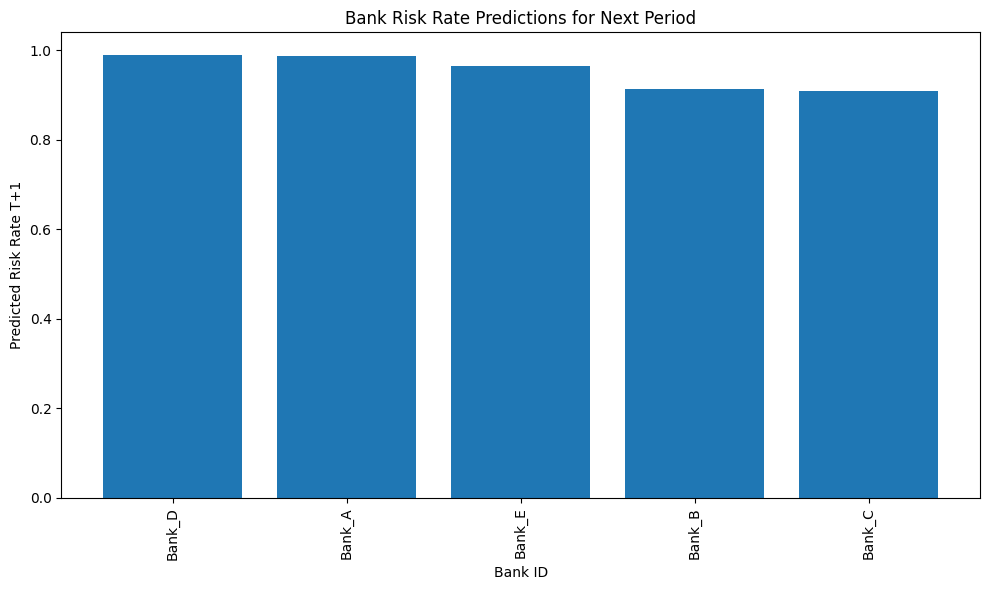

In [19]:
# Exemple d'utilisation :
feature_cols = [c for c in df.columns if c not in ["bank_id","date","risk_rate","risk_rate_t1","predicted_risk_rate_t1","risk_rate_real_t1","error_t1"]]
model, metrics_df, oof = train_backtest(df, feature_cols, n_splits=5, model_choice="gbrt", time_col="date")
# =====================================================
# 2️⃣ Rattacher les prédictions à la DataFrame principale
# =====================================================

TIME_COL = "date" if "date" in df.columns else "year"
df = df.sort_values([TIME_COL, "bank_id"]).copy()

# Ajouter les prédictions OOF (sorties du backtest)
df["predicted_risk_rate_t1"] = oof

# Reconstituer la vérité réelle à T+1 pour comparaison
df["risk_rate_real_t1"] = df.groupby("bank_id")["risk_rate"].shift(-1)

# Garder uniquement les lignes comparables
eval_df = df.dropna(subset=["predicted_risk_rate_t1", "risk_rate_real_t1"]).copy()

# Calculer l’erreur
eval_df["error_t1"] = eval_df["predicted_risk_rate_t1"] - eval_df["risk_rate_real_t1"]
fi_df = perm_importance(df, model, feature_cols, n_repeats=10)
print(fi_df.head(10))
forecast_df = forecast_last_period(df, model, feature_cols, time_col="date")
print(forecast_df)

#Graphique classement des banques
import matplotlib.pyplot as plt
forecast_df = forecast_df.sort_values("pred_risk_rate_Tplus1", ascending=False)
plt.figure(figsize=(10,6))
plt.bar(forecast_df["bank_id"].astype(str), forecast_df["pred_risk_rate_Tplus1"])
plt.xlabel("Bank ID")
plt.ylabel("Predicted Risk Rate T+1")
plt.title("Bank Risk Rate Predictions for Next Period")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


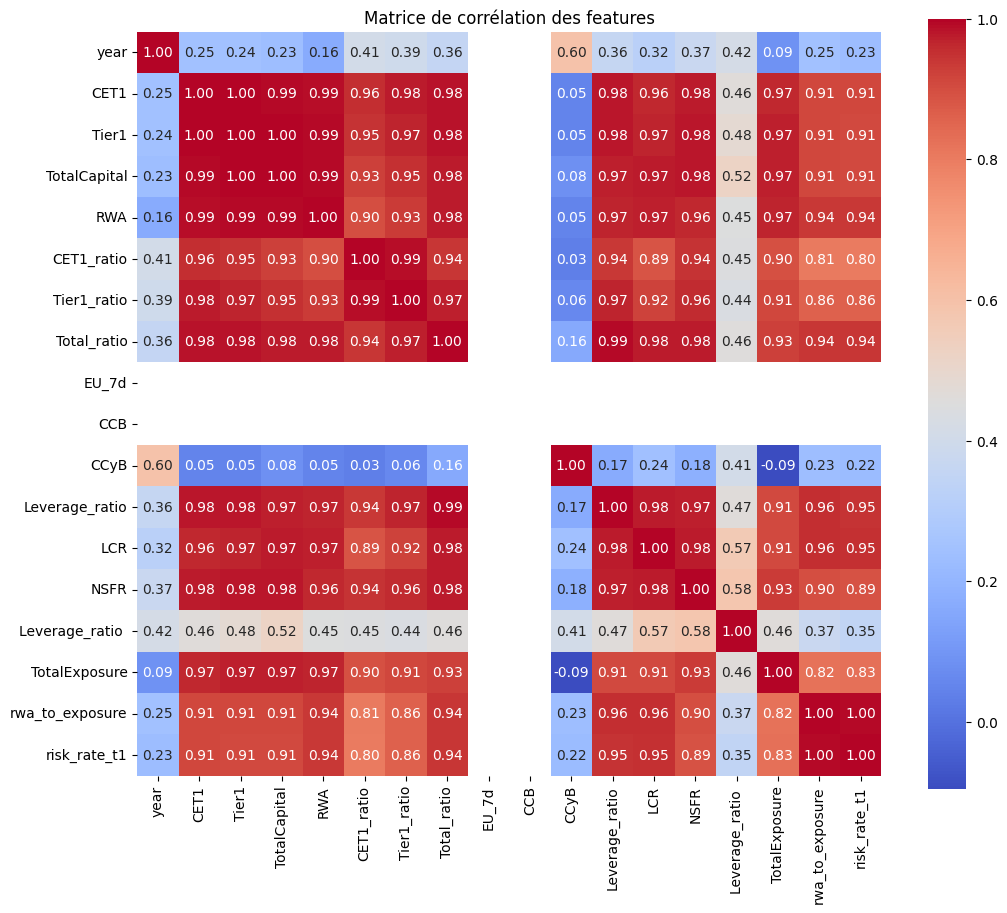

In [28]:
#Matrice de corrélation des features
#La matrice de corrélation permet de visualiser les relations linéaires entre les différentes features et la cible.
import seaborn as sns
plt.figure(figsize=(12,10))
corr = df[feature_cols + ["risk_rate_t1"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation des features")
plt.show()

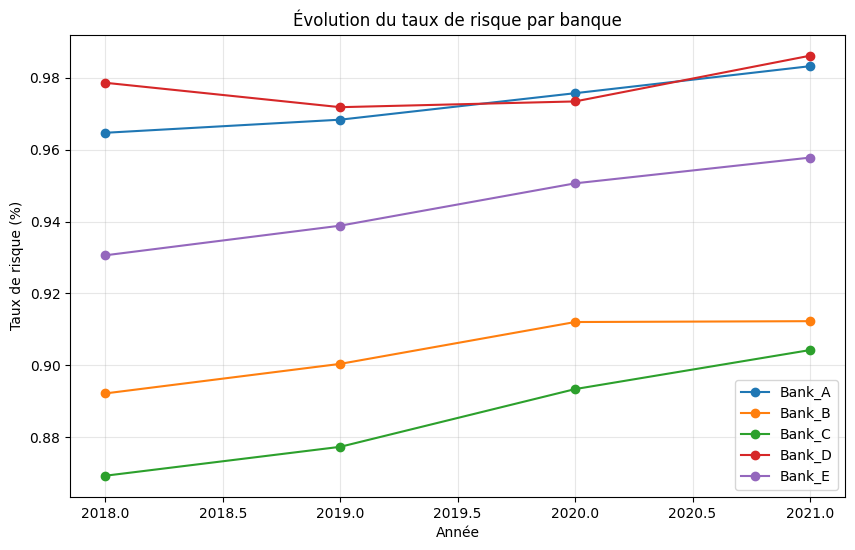

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for bank in df["bank_id"].unique():
    sub = df[df["bank_id"] == bank].sort_values("year")
    plt.plot(sub["year"], sub["risk_rate"], marker="o", label=bank)

plt.title("Évolution du taux de risque par banque")
plt.xlabel("Année")
plt.ylabel("Taux de risque (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

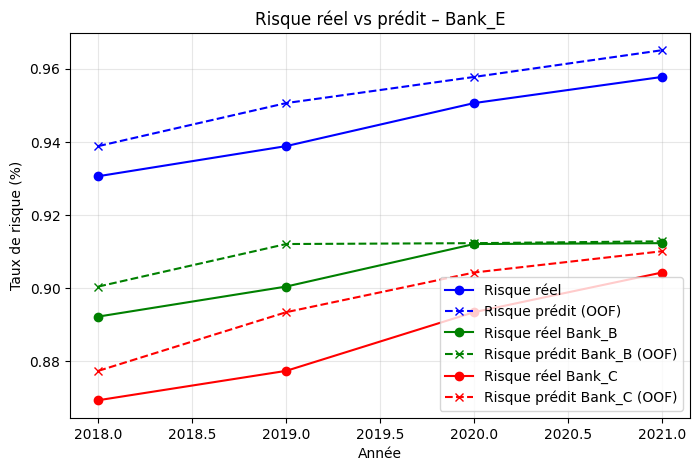

In [21]:
bank1 = "Bank_A"
bank2 = "Bank_B"
bank3 = "Bank_C"
sub = df[df["bank_id"] == bank].sort_values("year")
sub2 = df[df["bank_id"] == bank2].sort_values("year")
sub3 = df[df["bank_id"] == bank3].sort_values("year")

plt.figure(figsize=(8,5))
plt.plot(sub["year"], sub["risk_rate"], marker="o", label="Risque réel", color = "blue")
plt.plot(sub["year"], sub["risk_rate_t1"], marker="x", linestyle="--", label="Risque prédit (OOF)", color = "blue")
plt.plot(sub2["year"], sub2["risk_rate"], marker="o", label="Risque réel Bank_B", color = "green")
plt.plot(sub2["year"], sub2["risk_rate_t1"], marker="x", linestyle="--", label="Risque prédit Bank_B (OOF)", color = "green")
plt.plot(sub3["year"], sub3["risk_rate"], marker="o", label="Risque réel Bank_C", color = "red")
plt.plot(sub3["year"], sub3["risk_rate_t1"], marker="x", linestyle="--", label="Risque prédit Bank_C (OOF)", color = "red")
plt.title(f"Risque réel vs prédit – {bank}")
plt.xlabel("Année")
plt.ylabel("Taux de risque (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

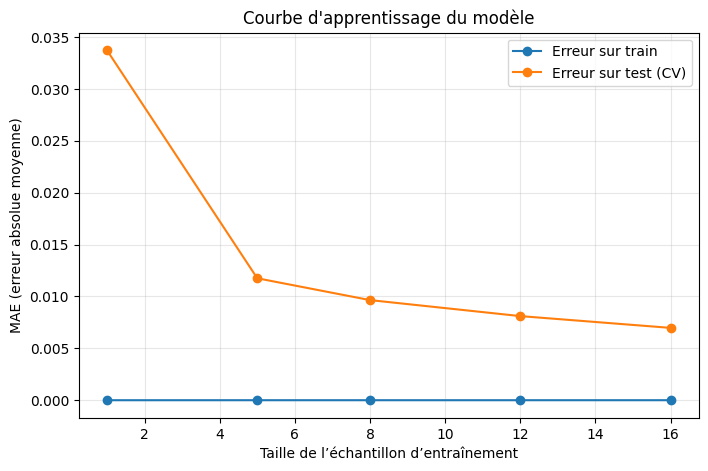

In [22]:
from sklearn.model_selection import learning_curve
import numpy as np

X = df[feature_cols]
y = df["risk_rate_t1"]

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)
test_mean  = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, "o-", label="Erreur sur train")
plt.plot(train_sizes, test_mean, "o-", label="Erreur sur test (CV)")
plt.title("Courbe d'apprentissage du modèle")
plt.xlabel("Taille de l’échantillon d’entraînement")
plt.ylabel("MAE (erreur absolue moyenne)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

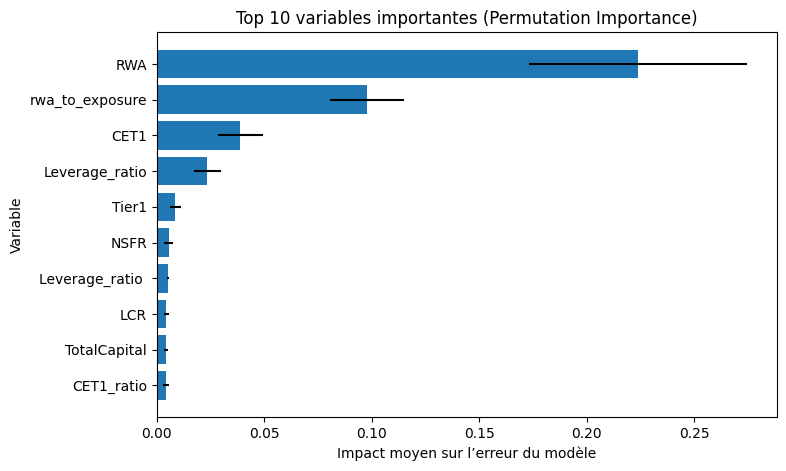

In [23]:
top = fi_df.sort_values("importance_mean", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
plt.gca().invert_yaxis()
plt.title("Top 10 variables importantes (Permutation Importance)")
plt.xlabel("Impact moyen sur l’erreur du modèle")
plt.ylabel("Variable")
plt.show()

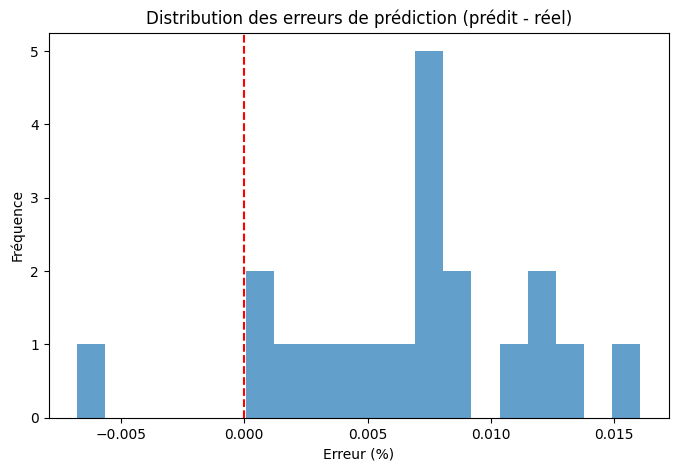

In [24]:
df["error"] = df["risk_rate_t1"] - df["risk_rate"]

plt.figure(figsize=(8,5))
plt.hist(df["error"], bins=20, alpha=0.7)
plt.title("Distribution des erreurs de prédiction (prédit - réel)")
plt.xlabel("Erreur (%)")
plt.ylabel("Fréquence")
plt.axvline(0, color="red", linestyle="--")
plt.show()

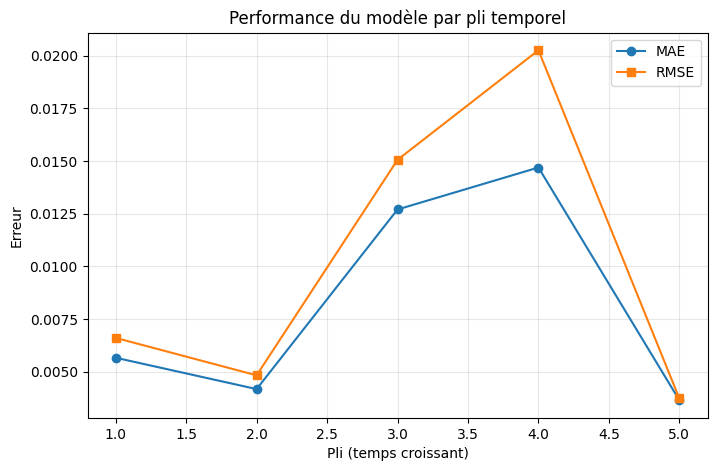

In [25]:
plt.figure(figsize=(8,5))
plt.plot(metrics_df["fold"], metrics_df["MAE"], marker="o", label="MAE")
plt.plot(metrics_df["fold"], metrics_df["RMSE"], marker="s", label="RMSE")
plt.title("Performance du modèle par pli temporel")
plt.xlabel("Pli (temps croissant)")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

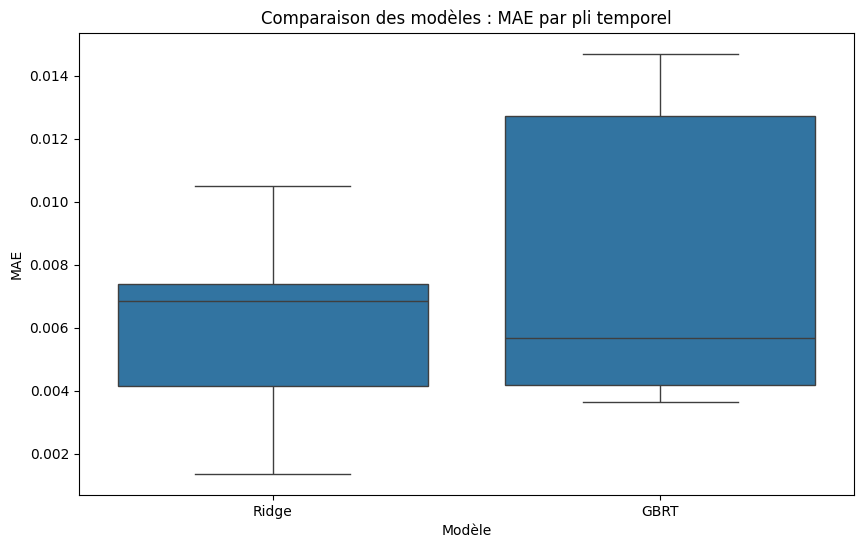

In [26]:
#Graphique de Comparaison des modèles Ridge vs GBRt
import seaborn as sns
metrics_ridge = []
metrics_gbrt = []
for model_choice in ["ridge", "gbrt"]:
    model, metrics_df, oof = train_backtest(df, feature_cols, n_splits=5, model_choice=model_choice, time_col="date")
    if model_choice == "ridge":
        metrics_ridge.append(metrics_df)
    else:
        metrics_gbrt.append(metrics_df)
# Fusionner les métriques pour le tracé
metrics_ridge_df = pd.concat(metrics_ridge)
metrics_ridge_df["model"] = "Ridge"
metrics_gbrt_df = pd.concat(metrics_gbrt)
metrics_gbrt_df["model"] = "GBRT"
all_metrics_df = pd.concat([metrics_ridge_df, metrics_gbrt_df]) 
plt.figure(figsize=(10,6))
sns.boxplot(x="model", y="MAE", data=all_metrics_df)
plt.title("Comparaison des modèles : MAE par pli temporel")
plt.xlabel("Modèle")
plt.ylabel("MAE")
plt.show()


